In [2]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_reacher import Agent
from unityagents import UnityEnvironment

# Load Reacher env with 20 agents
env = UnityEnvironment(file_name=r"Reacher_Windows_x86_64\Reacher.exe")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1] 

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [ ]:
def ddpg(agent, n_episodes=120, max_t=1000, training_mode=True):
    
    env_info = env.reset(train_mode=training_mode)[brain_name]      # reset the environment    

    total_scores = []
    
    for episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=training_mode)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                           # initialize the score (for each agent)
        agent.reset()
        
        for _ in range(max_t):
            actions = agent.act(states)

            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done
            
            if training_mode:
                agent.step(states, actions, rewards, next_states, dones) # send actions to the agent
            
            scores += env_info.rewards                          # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if np.any(dones):                                   # exit loop if episode finished
                break
        
        total_scores.append([np.mean(scores)])
        avg = np.mean(np.array(total_scores).T[0][-100:])
        print(f"Episode {episode}\t Average 100: {avg:.2f}\tMean rewards: {np.mean(scores):.2f})")

        if training_mode and np.mean(scores) > 35:
            torch.save(agent.actor_local.state_dict(), f'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoint_critic.pth')
    
    return total_scores, np.mean(np.array(total_scores).T[0][-100:])

Episode 1	 Average 100: 0.25	Mean rewards: 0.25)
Episode 2	 Average 100: 0.25	Mean rewards: 0.26)
Episode 3	 Average 100: 0.31	Mean rewards: 0.42)
Episode 4	 Average 100: 0.43	Mean rewards: 0.79)
Episode 5	 Average 100: 0.59	Mean rewards: 1.25)
Episode 6	 Average 100: 0.90	Mean rewards: 2.44)
Episode 7	 Average 100: 1.31	Mean rewards: 3.79)
Episode 8	 Average 100: 1.82	Mean rewards: 5.34)
Episode 9	 Average 100: 2.42	Mean rewards: 7.21)
Episode 10	 Average 100: 2.97	Mean rewards: 7.94)
Episode 11	 Average 100: 3.53	Mean rewards: 9.15)
Episode 12	 Average 100: 4.33	Mean rewards: 13.06)
Episode 13	 Average 100: 5.38	Mean rewards: 18.09)
Episode 14	 Average 100: 6.70	Mean rewards: 23.76)
Episode 15	 Average 100: 8.09	Mean rewards: 27.54)
Episode 16	 Average 100: 9.48	Mean rewards: 30.44)
Episode 17	 Average 100: 10.80	Mean rewards: 31.80)
Episode 18	 Average 100: 12.17	Mean rewards: 35.61)
Episode 19	 Average 100: 13.50	Mean rewards: 37.30)
Episode 20	 Average 100: 14.73	Mean rewards: 38.

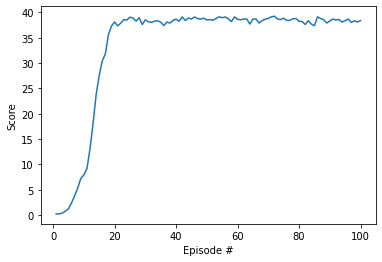

In [ ]:
# normal replay buffer
agent = Agent(state_size, action_size, None, False, 0)
scores, score = ddpg(agent, 100, 1000, True)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [3]:
# search for optimal hyper parameters
import optuna

def objective(trial):
    buffer_sizes = trial.suggest_int("buffer_sizes", int(1e5), int(1e6))
    batch_sizes = trial.suggest_int("batch_sizes", 64, 512, step=16)
    gammas = trial.suggest_float("gammas", 0.98, 0.999)
    taus = trial.suggest_loguniform("taus", 1e-3, 5e-3)
    lr_critic = trial.suggest_loguniform('lr_critic', 1e-4, 3e-4)
    lr_actor = trial.suggest_loguniform('lr_actor', 1e-4, 3e-4)
    weight_decays = trial.suggest_float("weight_decays", 0, 1e-3)
    theta = trial.suggest_loguniform('theta', 0.13, 0.26)
    sigma = trial.suggest_loguniform('sigma', 0.18, 0.22)
    mu = trial.suggest_float("mu", -0.01, 0.01)

    params = buffer_sizes, batch_sizes, gammas, taus, lr_actor, lr_critic, weight_decays, 400, 300, 256, 256, 128, mu, theta, sigma
  
    agent = Agent(state_size=33, action_size=4, hyper_params=params, PR=False, random_seed=0)
    _, score  = ddpg(agent, 40, 1000)
    return score  # Return the metric to optimize

pruner = optuna.pruners.ThresholdPruner(lower=10.0)

study = optuna.create_study(direction="maximize",pruner=pruner)
study.optimize(objective, n_trials=20)

print("Best hyperparameters: ", study.best_params)


[I 2024-11-05 10:50:56,052] A new study created in memory with name: no-name-924c7b0e-0a6c-4214-b46e-f75905578461
c:\Users\Emeis\.conda\envs\drlnd\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
c:\Users\Emeis\.conda\envs\drlnd\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
c:\Users\Emeis\.conda\envs\drlnd\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

Episode 1	 Average 100: 0.60	Mean rewards: 0.60)
Episode 2	 Average 100: 0.62	Mean rewards: 0.64)
Episode 3	 Average 100: 0.43	Mean rewards: 0.06)
Episode 4	 Average 100: 0.34	Mean rewards: 0.04)
Episode 5	 Average 100: 0.28	Mean rewards: 0.06)
Episode 6	 Average 100: 0.25	Mean rewards: 0.08)
Episode 7	 Average 100: 0.27	Mean rewards: 0.39)
Episode 8	 Average 100: 0.27	Mean rewards: 0.25)
Episode 9	 Average 100: 0.27	Mean rewards: 0.32)
Episode 10	 Average 100: 0.29	Mean rewards: 0.43)
Episode 11	 Average 100: 0.33	Mean rewards: 0.74)
Episode 12	 Average 100: 0.41	Mean rewards: 1.28)
Episode 13	 Average 100: 0.50	Mean rewards: 1.61)
Episode 14	 Average 100: 0.60	Mean rewards: 1.88)
Episode 15	 Average 100: 0.68	Mean rewards: 1.76)
Episode 16	 Average 100: 0.79	Mean rewards: 2.51)
Episode 17	 Average 100: 0.90	Mean rewards: 2.70)
Episode 18	 Average 100: 1.00	Mean rewards: 2.67)
Episode 19	 Average 100: 1.11	Mean rewards: 3.04)
Episode 20	 Average 100: 1.23	Mean rewards: 3.54)
Episode 2

[I 2024-11-05 11:08:29,939] Trial 0 finished with value: 5.116049885647371 and parameters: {'buffer_sizes': 518141, 'batch_sizes': 112, 'gammas': 0.9839998244390682, 'taus': 0.001997429257598519, 'lr_critic': 0.00010638326522030587, 'lr_actor': 0.00023689979546505634, 'weight_decays': 0.00020124742727088764, 'theta': 0.2236414129715101, 'sigma': 0.18652055385985936, 'mu': -0.00730357297268262}. Best is trial 0 with value: 5.116049885647371.


Episode 1	 Average 100: 0.51	Mean rewards: 0.51)
Episode 2	 Average 100: 0.48	Mean rewards: 0.45)
Episode 3	 Average 100: 0.41	Mean rewards: 0.26)
Episode 4	 Average 100: 0.42	Mean rewards: 0.44)
Episode 5	 Average 100: 0.35	Mean rewards: 0.09)
Episode 6	 Average 100: 0.30	Mean rewards: 0.02)
Episode 7	 Average 100: 0.25	Mean rewards: 0.00)
Episode 8	 Average 100: 0.24	Mean rewards: 0.16)
Episode 9	 Average 100: 0.28	Mean rewards: 0.60)
Episode 10	 Average 100: 0.38	Mean rewards: 1.31)
Episode 11	 Average 100: 0.48	Mean rewards: 1.40)
Episode 12	 Average 100: 0.56	Mean rewards: 1.50)
Episode 13	 Average 100: 0.68	Mean rewards: 2.15)
Episode 14	 Average 100: 0.79	Mean rewards: 2.23)
Episode 15	 Average 100: 0.91	Mean rewards: 2.52)
Episode 16	 Average 100: 1.10	Mean rewards: 3.98)
Episode 17	 Average 100: 1.28	Mean rewards: 4.16)
Episode 18	 Average 100: 1.50	Mean rewards: 5.24)
Episode 19	 Average 100: 1.72	Mean rewards: 5.57)
Episode 20	 Average 100: 1.95	Mean rewards: 6.43)
Episode 2

[I 2024-11-05 11:27:14,324] Trial 1 finished with value: 7.44081233368488 and parameters: {'buffer_sizes': 605589, 'batch_sizes': 160, 'gammas': 0.9951742064324076, 'taus': 0.0011571063695320792, 'lr_critic': 0.00017931360491097034, 'lr_actor': 0.00010762297044263683, 'weight_decays': 0.00022337739451042628, 'theta': 0.20658443985931152, 'sigma': 0.18429456663730875, 'mu': -0.007020408743652465}. Best is trial 1 with value: 7.44081233368488.


Episode 40	 Average 100: 7.44	Mean rewards: 16.31)
Episode 1	 Average 100: 0.72	Mean rewards: 0.72)
Episode 2	 Average 100: 0.78	Mean rewards: 0.84)
Episode 3	 Average 100: 0.70	Mean rewards: 0.55)
Episode 4	 Average 100: 0.81	Mean rewards: 1.13)
Episode 5	 Average 100: 0.86	Mean rewards: 1.05)
Episode 6	 Average 100: 0.99	Mean rewards: 1.64)
Episode 7	 Average 100: 1.14	Mean rewards: 2.02)
Episode 8	 Average 100: 1.37	Mean rewards: 2.96)
Episode 9	 Average 100: 1.56	Mean rewards: 3.09)
Episode 10	 Average 100: 1.72	Mean rewards: 3.14)
Episode 11	 Average 100: 1.92	Mean rewards: 3.98)
Episode 12	 Average 100: 2.15	Mean rewards: 4.71)
Episode 13	 Average 100: 2.46	Mean rewards: 6.12)
Episode 14	 Average 100: 2.80	Mean rewards: 7.20)
Episode 15	 Average 100: 3.20	Mean rewards: 8.82)
Episode 16	 Average 100: 3.69	Mean rewards: 11.01)
Episode 17	 Average 100: 4.26	Mean rewards: 13.50)
Episode 18	 Average 100: 4.88	Mean rewards: 15.33)
Episode 19	 Average 100: 5.60	Mean rewards: 18.61)
Epis

[I 2024-11-05 11:44:05,785] Trial 2 finished with value: 19.112874572793952 and parameters: {'buffer_sizes': 888796, 'batch_sizes': 96, 'gammas': 0.9975021421117618, 'taus': 0.0020636297627618654, 'lr_critic': 0.0001477153636777279, 'lr_actor': 0.00017850380520611722, 'weight_decays': 0.0006330615621490876, 'theta': 0.19712763430884483, 'sigma': 0.21211552515658802, 'mu': -0.0030956838685223653}. Best is trial 2 with value: 19.112874572793952.


Episode 1	 Average 100: 0.92	Mean rewards: 0.92)
Episode 2	 Average 100: 1.00	Mean rewards: 1.09)
Episode 3	 Average 100: 1.15	Mean rewards: 1.45)
Episode 4	 Average 100: 1.55	Mean rewards: 2.76)
Episode 5	 Average 100: 1.90	Mean rewards: 3.26)
Episode 6	 Average 100: 2.18	Mean rewards: 3.59)
Episode 7	 Average 100: 2.51	Mean rewards: 4.51)
Episode 8	 Average 100: 3.00	Mean rewards: 6.45)
Episode 9	 Average 100: 3.60	Mean rewards: 8.41)
Episode 10	 Average 100: 4.31	Mean rewards: 10.68)
Episode 11	 Average 100: 5.01	Mean rewards: 11.95)
Episode 12	 Average 100: 5.67	Mean rewards: 12.92)
Episode 13	 Average 100: 6.27	Mean rewards: 13.54)
Episode 14	 Average 100: 6.79	Mean rewards: 13.55)
Episode 15	 Average 100: 7.29	Mean rewards: 14.23)
Episode 16	 Average 100: 7.78	Mean rewards: 15.21)
Episode 17	 Average 100: 8.22	Mean rewards: 15.29)
Episode 18	 Average 100: 8.71	Mean rewards: 17.04)
Episode 19	 Average 100: 9.14	Mean rewards: 16.80)
Episode 20	 Average 100: 9.52	Mean rewards: 16.73

[I 2024-11-05 12:04:15,904] Trial 3 finished with value: 14.47876217637444 and parameters: {'buffer_sizes': 849573, 'batch_sizes': 176, 'gammas': 0.9883252024819398, 'taus': 0.0026795713962064105, 'lr_critic': 0.0002274551845212866, 'lr_actor': 0.00021345571381741754, 'weight_decays': 0.0005579066634443088, 'theta': 0.23023215425225058, 'sigma': 0.18060902160980435, 'mu': 0.006905354307548605}. Best is trial 2 with value: 19.112874572793952.


Episode 1	 Average 100: 0.74	Mean rewards: 0.74)
Episode 2	 Average 100: 0.90	Mean rewards: 1.06)
Episode 3	 Average 100: 0.99	Mean rewards: 1.17)
Episode 4	 Average 100: 1.06	Mean rewards: 1.27)
Episode 5	 Average 100: 1.14	Mean rewards: 1.48)
Episode 6	 Average 100: 1.20	Mean rewards: 1.49)
Episode 7	 Average 100: 1.31	Mean rewards: 1.93)
Episode 8	 Average 100: 1.38	Mean rewards: 1.89)
Episode 9	 Average 100: 1.44	Mean rewards: 1.92)
Episode 10	 Average 100: 1.49	Mean rewards: 1.96)
Episode 11	 Average 100: 1.57	Mean rewards: 2.37)
Episode 12	 Average 100: 1.67	Mean rewards: 2.76)
Episode 13	 Average 100: 1.74	Mean rewards: 2.61)
Episode 14	 Average 100: 1.90	Mean rewards: 3.89)
Episode 15	 Average 100: 2.14	Mean rewards: 5.53)
Episode 16	 Average 100: 2.41	Mean rewards: 6.46)
Episode 17	 Average 100: 2.70	Mean rewards: 7.40)
Episode 18	 Average 100: 3.04	Mean rewards: 8.84)
Episode 19	 Average 100: 3.48	Mean rewards: 11.26)
Episode 20	 Average 100: 3.89	Mean rewards: 11.78)
Episode

[I 2024-11-05 12:31:16,173] Trial 4 finished with value: 14.559737174564509 and parameters: {'buffer_sizes': 351779, 'batch_sizes': 304, 'gammas': 0.9803772526111684, 'taus': 0.0017068756023217813, 'lr_critic': 0.00015390752981175713, 'lr_actor': 0.00025374811124088774, 'weight_decays': 0.0003257981452160752, 'theta': 0.2119931333597613, 'sigma': 0.19601633119274556, 'mu': -0.00410728566462379}. Best is trial 2 with value: 19.112874572793952.


Episode 40	 Average 100: 14.56	Mean rewards: 36.53)
Episode 1	 Average 100: 0.61	Mean rewards: 0.61)
Episode 2	 Average 100: 0.53	Mean rewards: 0.45)
Episode 3	 Average 100: 0.63	Mean rewards: 0.83)
Episode 4	 Average 100: 0.76	Mean rewards: 1.13)
Episode 5	 Average 100: 1.02	Mean rewards: 2.09)
Episode 6	 Average 100: 1.27	Mean rewards: 2.50)
Episode 7	 Average 100: 1.71	Mean rewards: 4.35)
Episode 8	 Average 100: 2.25	Mean rewards: 6.07)
Episode 9	 Average 100: 2.95	Mean rewards: 8.52)
Episode 10	 Average 100: 3.90	Mean rewards: 12.48)
Episode 11	 Average 100: 5.13	Mean rewards: 17.36)
Episode 12	 Average 100: 6.38	Mean rewards: 20.13)
Episode 13	 Average 100: 7.74	Mean rewards: 24.09)
Episode 14	 Average 100: 9.23	Mean rewards: 28.64)
Episode 15	 Average 100: 10.77	Mean rewards: 32.26)
Episode 16	 Average 100: 12.44	Mean rewards: 37.51)
Episode 17	 Average 100: 14.00	Mean rewards: 39.01)
Episode 18	 Average 100: 15.35	Mean rewards: 38.28)
Episode 19	 Average 100: 16.60	Mean rewards:

[I 2024-11-05 12:57:36,649] Trial 5 finished with value: 28.200036869680048 and parameters: {'buffer_sizes': 909973, 'batch_sizes': 384, 'gammas': 0.9901736020389454, 'taus': 0.0018092674864975023, 'lr_critic': 0.00019323989991911093, 'lr_actor': 0.00017377360292847218, 'weight_decays': 0.0007434075695379568, 'theta': 0.20215485858989818, 'sigma': 0.2053184766109179, 'mu': -0.0036382192060112045}. Best is trial 5 with value: 28.200036869680048.


Episode 1	 Average 100: 0.66	Mean rewards: 0.66)
Episode 2	 Average 100: 0.75	Mean rewards: 0.85)
Episode 3	 Average 100: 0.86	Mean rewards: 1.07)
Episode 4	 Average 100: 1.00	Mean rewards: 1.43)
Episode 5	 Average 100: 1.22	Mean rewards: 2.07)
Episode 6	 Average 100: 1.49	Mean rewards: 2.87)
Episode 7	 Average 100: 1.91	Mean rewards: 4.40)
Episode 8	 Average 100: 2.36	Mean rewards: 5.53)
Episode 9	 Average 100: 2.84	Mean rewards: 6.70)
Episode 10	 Average 100: 3.42	Mean rewards: 8.65)
Episode 11	 Average 100: 4.07	Mean rewards: 10.50)
Episode 12	 Average 100: 4.60	Mean rewards: 10.46)
Episode 13	 Average 100: 5.16	Mean rewards: 11.91)
Episode 14	 Average 100: 5.71	Mean rewards: 12.77)
Episode 15	 Average 100: 6.20	Mean rewards: 13.11)
Episode 16	 Average 100: 6.70	Mean rewards: 14.20)
Episode 17	 Average 100: 7.24	Mean rewards: 15.82)
Episode 18	 Average 100: 7.77	Mean rewards: 16.82)
Episode 19	 Average 100: 8.24	Mean rewards: 16.66)
Episode 20	 Average 100: 8.72	Mean rewards: 17.81)

[I 2024-11-05 13:12:53,494] Trial 6 finished with value: 18.527524585877547 and parameters: {'buffer_sizes': 287830, 'batch_sizes': 256, 'gammas': 0.9829797047531849, 'taus': 0.002327307658400946, 'lr_critic': 0.00018726285456079563, 'lr_actor': 0.0002667421279152214, 'weight_decays': 0.0001328768062504383, 'theta': 0.17116235802616078, 'sigma': 0.1843290586519753, 'mu': -0.000890800407315151}. Best is trial 5 with value: 28.200036869680048.


Episode 40	 Average 100: 18.53	Mean rewards: 36.59)
Episode 1	 Average 100: 0.36	Mean rewards: 0.36)
Episode 2	 Average 100: 0.54	Mean rewards: 0.72)
Episode 3	 Average 100: 0.63	Mean rewards: 0.81)
Episode 4	 Average 100: 0.87	Mean rewards: 1.61)
Episode 5	 Average 100: 1.33	Mean rewards: 3.14)
Episode 6	 Average 100: 1.91	Mean rewards: 4.80)
Episode 7	 Average 100: 2.61	Mean rewards: 6.85)
Episode 8	 Average 100: 3.39	Mean rewards: 8.84)
Episode 9	 Average 100: 4.34	Mean rewards: 11.90)
Episode 10	 Average 100: 5.17	Mean rewards: 12.73)
Episode 11	 Average 100: 6.24	Mean rewards: 16.88)
Episode 12	 Average 100: 7.32	Mean rewards: 19.23)
Episode 13	 Average 100: 8.33	Mean rewards: 20.39)
Episode 14	 Average 100: 9.40	Mean rewards: 23.30)
Episode 15	 Average 100: 10.46	Mean rewards: 25.42)
Episode 16	 Average 100: 11.63	Mean rewards: 29.12)
Episode 17	 Average 100: 12.75	Mean rewards: 30.67)
Episode 18	 Average 100: 13.83	Mean rewards: 32.21)
Episode 19	 Average 100: 14.87	Mean rewards

[I 2024-11-05 13:43:29,471] Trial 7 finished with value: 27.10223689421779 and parameters: {'buffer_sizes': 467453, 'batch_sizes': 416, 'gammas': 0.9934566329254713, 'taus': 0.0027702374602865177, 'lr_critic': 0.0001640975379323541, 'lr_actor': 0.00013825448670382097, 'weight_decays': 0.00034755128181723197, 'theta': 0.16875285383336636, 'sigma': 0.20930939605188145, 'mu': 0.00262204221368683}. Best is trial 5 with value: 28.200036869680048.


Episode 40	 Average 100: 27.10	Mean rewards: 38.57)
Episode 1	 Average 100: 0.84	Mean rewards: 0.84)
Episode 2	 Average 100: 1.07	Mean rewards: 1.31)
Episode 3	 Average 100: 1.18	Mean rewards: 1.39)
Episode 4	 Average 100: 1.53	Mean rewards: 2.61)
Episode 5	 Average 100: 1.99	Mean rewards: 3.82)
Episode 6	 Average 100: 2.50	Mean rewards: 5.05)
Episode 7	 Average 100: 3.22	Mean rewards: 7.57)
Episode 8	 Average 100: 4.02	Mean rewards: 9.61)
Episode 9	 Average 100: 4.92	Mean rewards: 12.06)
Episode 10	 Average 100: 5.58	Mean rewards: 11.56)
Episode 11	 Average 100: 6.22	Mean rewards: 12.59)
Episode 12	 Average 100: 6.93	Mean rewards: 14.73)
Episode 13	 Average 100: 7.85	Mean rewards: 18.97)
Episode 14	 Average 100: 8.69	Mean rewards: 19.60)
Episode 15	 Average 100: 9.60	Mean rewards: 22.26)
Episode 16	 Average 100: 10.51	Mean rewards: 24.16)
Episode 17	 Average 100: 11.49	Mean rewards: 27.13)
Episode 18	 Average 100: 12.52	Mean rewards: 30.02)
Episode 19	 Average 100: 13.54	Mean rewards:

[I 2024-11-05 14:03:23,445] Trial 8 finished with value: 26.205211914267853 and parameters: {'buffer_sizes': 217375, 'batch_sizes': 352, 'gammas': 0.9846615032336302, 'taus': 0.002875598432836749, 'lr_critic': 0.0002805049320302273, 'lr_actor': 0.00020615938569614224, 'weight_decays': 0.0009376184114565765, 'theta': 0.21407593119227603, 'sigma': 0.2176423318864101, 'mu': 0.0035163949303336113}. Best is trial 5 with value: 28.200036869680048.


Episode 40	 Average 100: 26.21	Mean rewards: 38.60)
Episode 1	 Average 100: 0.28	Mean rewards: 0.28)
Episode 2	 Average 100: 0.32	Mean rewards: 0.35)
Episode 3	 Average 100: 0.29	Mean rewards: 0.22)
Episode 4	 Average 100: 0.25	Mean rewards: 0.13)
Episode 5	 Average 100: 0.25	Mean rewards: 0.28)
Episode 6	 Average 100: 0.33	Mean rewards: 0.74)
Episode 7	 Average 100: 0.55	Mean rewards: 1.86)
Episode 8	 Average 100: 0.79	Mean rewards: 2.41)
Episode 9	 Average 100: 1.05	Mean rewards: 3.13)
Episode 10	 Average 100: 1.34	Mean rewards: 3.99)
Episode 11	 Average 100: 1.62	Mean rewards: 4.41)
Episode 12	 Average 100: 1.98	Mean rewards: 5.88)
Episode 13	 Average 100: 2.27	Mean rewards: 5.84)
Episode 14	 Average 100: 2.61	Mean rewards: 6.94)
Episode 15	 Average 100: 2.93	Mean rewards: 7.52)
Episode 16	 Average 100: 3.34	Mean rewards: 9.49)
Episode 17	 Average 100: 3.82	Mean rewards: 11.36)
Episode 18	 Average 100: 4.33	Mean rewards: 13.01)
Episode 19	 Average 100: 4.78	Mean rewards: 12.87)
Epis

[I 2024-11-05 14:22:55,535] Trial 9 finished with value: 14.080824685269036 and parameters: {'buffer_sizes': 789726, 'batch_sizes': 192, 'gammas': 0.9892006373737653, 'taus': 0.002126201282613287, 'lr_critic': 0.0001974533292235345, 'lr_actor': 0.00012283896167098428, 'weight_decays': 0.0009143051066780893, 'theta': 0.2413929300603549, 'sigma': 0.19114945494405894, 'mu': 0.0005375059327882466}. Best is trial 5 with value: 28.200036869680048.


Episode 1	 Average 100: 0.78	Mean rewards: 0.78)
Episode 2	 Average 100: 0.80	Mean rewards: 0.81)
Episode 3	 Average 100: 0.95	Mean rewards: 1.24)
Episode 4	 Average 100: 1.32	Mean rewards: 2.45)
Episode 5	 Average 100: 1.89	Mean rewards: 4.16)
Episode 6	 Average 100: 2.48	Mean rewards: 5.43)
Episode 7	 Average 100: 3.39	Mean rewards: 8.83)
Episode 8	 Average 100: 4.32	Mean rewards: 10.86)
Episode 9	 Average 100: 5.44	Mean rewards: 14.40)
Episode 10	 Average 100: 6.51	Mean rewards: 16.09)
Episode 11	 Average 100: 7.66	Mean rewards: 19.19)
Episode 12	 Average 100: 8.86	Mean rewards: 22.11)
Episode 13	 Average 100: 9.94	Mean rewards: 22.90)
Episode 14	 Average 100: 11.10	Mean rewards: 26.17)
Episode 15	 Average 100: 12.38	Mean rewards: 30.25)
Episode 16	 Average 100: 13.58	Mean rewards: 31.64)
Episode 17	 Average 100: 14.62	Mean rewards: 31.20)
Episode 18	 Average 100: 15.70	Mean rewards: 33.99)
Episode 19	 Average 100: 16.68	Mean rewards: 34.37)
Episode 20	 Average 100: 17.59	Mean rewar

[W 2024-11-05 14:44:37,642] Trial 10 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Emeis\AppData\Roaming\Python\Python36\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-3-d97d8655e2e9>", line 19, in objective
    _, score  = ddpg(agent, 40, 1000)
  File "<ipython-input-2-469310edd211>", line 22, in ddpg
    agent.step(states, actions, rewards, next_states, dones) # send actions to the agent
  File "c:\Users\Emeis\Documents\udacity\project2-reacher\ddpg_reacher.py", line 89, in step
    self.learn(experiences, self.gamma)
  File "c:\Users\Emeis\Documents\udacity\project2-reacher\ddpg_reacher.py", line 149, in learn
    critic_loss.backward()
  File "c:\Users\Emeis\.conda\envs\drlnd\lib\site-packages\torch\tensor.py", line 93, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "c:\Users\Emeis\.conda\envs\drlnd\

KeyboardInterrupt: 

Episode 1	 Average 100: 38.80	Mean rewards: 38.80)
Episode 2	 Average 100: 38.61	Mean rewards: 38.41)
Episode 3	 Average 100: 38.60	Mean rewards: 38.58)
Episode 4	 Average 100: 38.58	Mean rewards: 38.55)
Episode 5	 Average 100: 38.55	Mean rewards: 38.41)
Episode 6	 Average 100: 38.56	Mean rewards: 38.58)
Episode 7	 Average 100: 38.59	Mean rewards: 38.76)
Episode 8	 Average 100: 38.57	Mean rewards: 38.48)
Episode 9	 Average 100: 38.59	Mean rewards: 38.76)
Episode 10	 Average 100: 38.56	Mean rewards: 38.21)
Episode 11	 Average 100: 38.57	Mean rewards: 38.71)
Episode 12	 Average 100: 38.59	Mean rewards: 38.85)
Episode 13	 Average 100: 38.59	Mean rewards: 38.58)
Episode 14	 Average 100: 38.55	Mean rewards: 38.01)
Episode 15	 Average 100: 38.53	Mean rewards: 38.22)
Episode 16	 Average 100: 38.54	Mean rewards: 38.66)
Episode 17	 Average 100: 38.52	Mean rewards: 38.32)
Episode 18	 Average 100: 38.54	Mean rewards: 38.77)
Episode 19	 Average 100: 38.55	Mean rewards: 38.71)
Episode 20	 Average 1

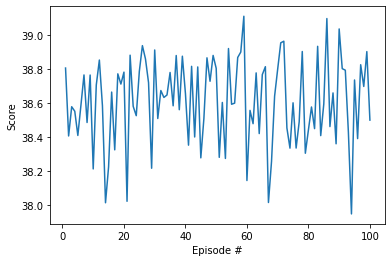

In [4]:
# load actor with saved weights, run ddpg in evaluation mode

agent = Agent(state_size, action_size, None, False, 0)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
scores, score = ddpg(agent, 100, 1000, False)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()